### LAB 2

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import quad

In [2]:
#Constants
G = 6.6743e-11            #Gravational Constant                  m^3/kg/s^2
Go = 9.81                 #Gravitational Acceleration            m/s^2
M_earth = 5.972e24        #Mass of the Earth                     kg
M_moon = 7.35e22          #Mass of the Moon                      kg
R_earth = 6.37e6          #Radius of the Earth                   m
R_moon = 1737.1           #Radius of the Moon                    km
Earth_Rr_E = 7.272e5      #Earth's Rotation Rate at the Equator  rad/s
h = 4000                  #Shaft Depth                           m
w = 5                     #Shaft Width
v_terminal = 50           #Terminal Velocity                     m/s
Omega = 7.2921159E-5

Part 1

Calculated Free Fall Time:28.6 seconds
Solved Free Fall Time: 28.6 seconds


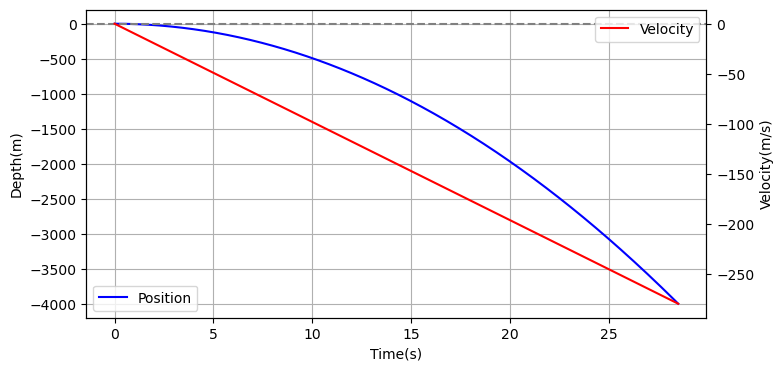

In [10]:
#How long it'll take for mass to reach the bottom of the shaft(calculated)
def free_fall_time(h, Go):
    return np.sqrt(2*h/Go)
    
T_calculated = free_fall_time(h, Go)
print(f"Calculated Free Fall Time:{T_calculated:.1f} seconds")

#Define second-order DE equation pt1.
def derivativept1(t, y):
    position, velocity = y
    dposition_dt = velocity
    dvelocity_dt = -Go
    return [dposition_dt, dvelocity_dt]

#Event function
def hit_ground(t, y):
    return y[0] + h
hit_ground.terminal = True
hit_ground.direction = -1

y0 = [0, 0]
soln = solve_ivp(derivativept1, (0, (2*T_calculated)), y0, t_eval = np.linspace(0, 2*T_calculated, 1000), events = hit_ground)

#Plot
t = soln.t
position = soln.y[0]
velocity = soln.y[1]

fig, ax1 = plt.subplots(figsize = (8, 4))

ax1.plot(t, position, label = 'Position', color = 'b')
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Depth(m)")
ax1.axhline(0, linestyle = 'dashed', color = 'gray')
ax1.legend()
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(t, velocity, label = 'Velocity', color = 'r')
ax2.set_ylabel("Velocity(m/s)")
ax2.legend()

#How long it'll take for mass to reach the bottom of the shaft(numerical)
T_solved = soln.t_events[0][0]
print(f"Solved Free Fall Time: {T_solved:.1f} seconds")

Part 2

Analytic fall time (no drag): 1265.77 seconds
Calibrated alpha for terminal speed of 50 m/s: 0.003924
Simulated fall time to y=0 (no drag): 1266.53 s
The object did not reach y=0 during the simulation for t_cross_drag.


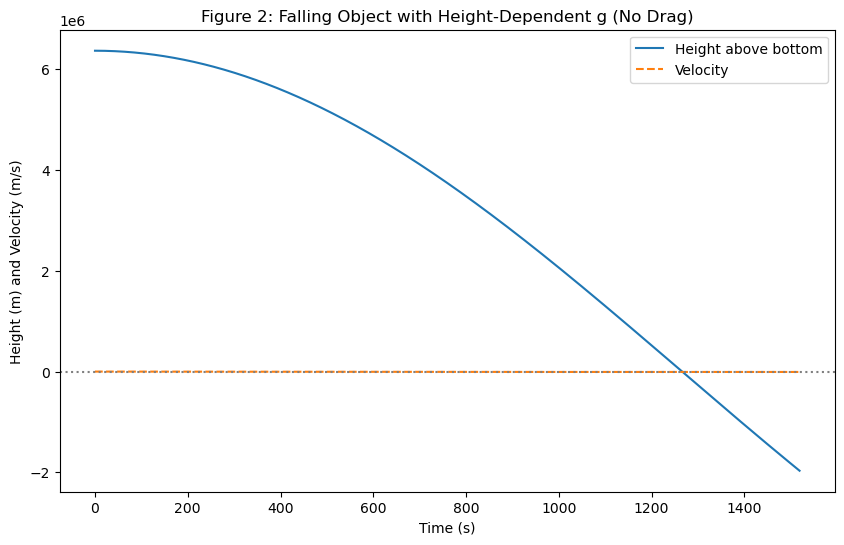

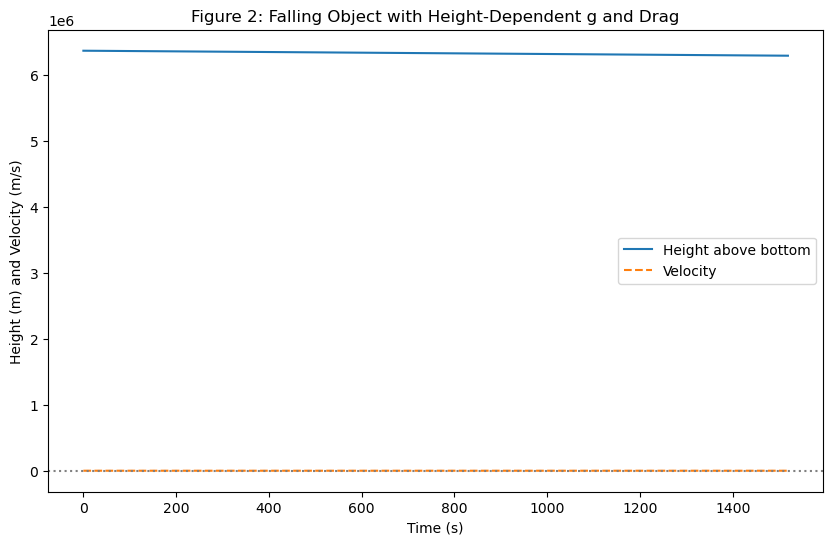

In [29]:
#Using the Class function
class FallingObject:  
    def __init__(self, R, g0, alpha=0.0, gamma=2):
        self.R = R            #Earth's Radius
        self.g0 = g0          #Acceleration due to gravity
        self.alpha = alpha    #Drag Coefficient
        self.gamma = gamma    #Exponent in Drag law

    def deriv(self, t, state):
        #y is height above the bottom, v = dy/dt(negative for falling downward)
        y, v = state
        grav_a = - self.g0 * (y / self.R)  #Gravitaional Acceleration(Directed downward)
        drag_a = - self.alpha * (abs(v)**(self.gamma - 1)) * v #Drag Acceleration(Opposes motion)
        return [v, grav_a + drag_a]

    def simulate(self, t_max, num_points=1000):
        t_span = (0, t_max)
        init_state = [self.R, 0]  
        sol = solve_ivp(self.deriv, t_span, init_state, t_eval=np.linspace(0, t_max, num_points), rtol=1e-8, atol=1e-10)
        return sol.t, sol.y[0], sol.y[1]

R = 6.37e6      # Earth's Radius(m)
g0 = 9.81       # Gravitational Acceleration(m/s^2)

# Analytic fall time (no drag) using the SHO solution:
t_fall_analytic = (np.pi/2) * np.sqrt(R / g0)
print(f"Analytic fall time (no drag): {t_fall_analytic:.2f} seconds")

t_max = t_fall_analytic * 1.2 #Stimulation time longer than fall time

#Simulation with Height-Dependent g (No Drag)
fall_obj_no_drag = FallingObject(R, g0, alpha = 0.0, gamma = 2)
t_nd, y_nd, v_nd = fall_obj_no_drag.simulate(t_max)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_nd, y_nd, label='Height above bottom')
ax.plot(t_nd, v_nd, label='Velocity', linestyle='--')
ax.axhline(0, color='gray', linestyle=':')  #Mark the bottom (y=0)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Height (m) and Velocity (m/s)")
ax.set_title("Figure 2: Falling Object with Height-Dependent g (No Drag)")
ax.legend()

# Simulation with Drag 
v_term = 50.0  # Calibrating drag using a terminal speed of 50m/s
alpha_calibrated = g0 / (v_term**2)  #g0 = alpha * v_term^2  => alpha = g0/(v_term^2)
print(f"Calibrated alpha for terminal speed of 50 m/s: {alpha_calibrated:.6f}")

fall_obj_drag = FallingObject(R, g0, alpha=alpha_calibrated, gamma=2)
t_d, y_d, v_d = fall_obj_drag.simulate(t_max)
# print(t_d, y_d, v_d)

fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(t_d, y_d, label='Height above bottom')
ax2.plot(t_d, v_d, label='Velocity', linestyle='--')
ax2.axhline(0, color='gray', linestyle=':')  # bottom of the shaft
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Height (m) and Velocity (m/s)")
ax2.set_title("Figure 2: Falling Object with Height-Dependent g and Drag")
ax2.legend()

#Comparing Fall Times:
def find_crossing_time(t, y):
    idx = np.where(y <= 0)[0]   #Return the first time when y goes to or below 0 (i.e. reaches the bottom)
    if len(idx) > 0:
        return t[idx[0]]
    else:
        return None
t_cross_no_drag = find_crossing_time(t_nd, y_nd)
t_cross_drag = find_crossing_time(t_d, y_d)

if t_cross_no_drag is not None:
    print(f"Simulated fall time to y=0 (no drag): {t_cross_no_drag:.2f} s")
else:
    print("The object did not reach y=0 during the simulation.")

if t_cross_drag is not None:
    print(f"Simulated fall time to y=0 (with drag): {t_cross_drag:.2f} s")
else:
    print("The object did not reach y=0 during the simulation for t_cross_drag.")

Part 3

Simulation without drag completed. Final time: 28.56 s
Event time: [array([28.5568831])]
Simulation with drag (gamma=0.05) completed. Final time: 37.29 s
Event time: [array([37.28753419])]


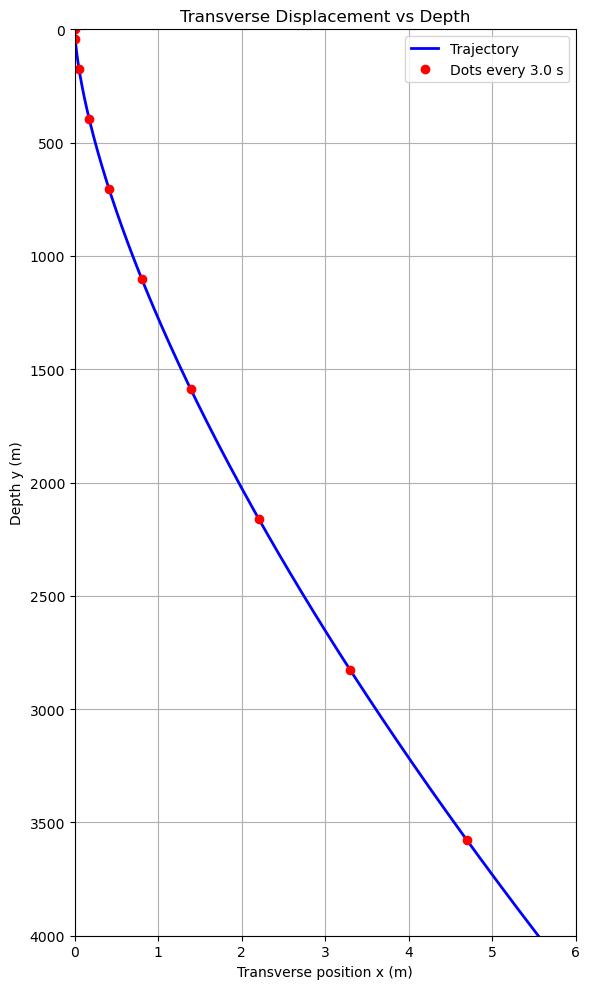

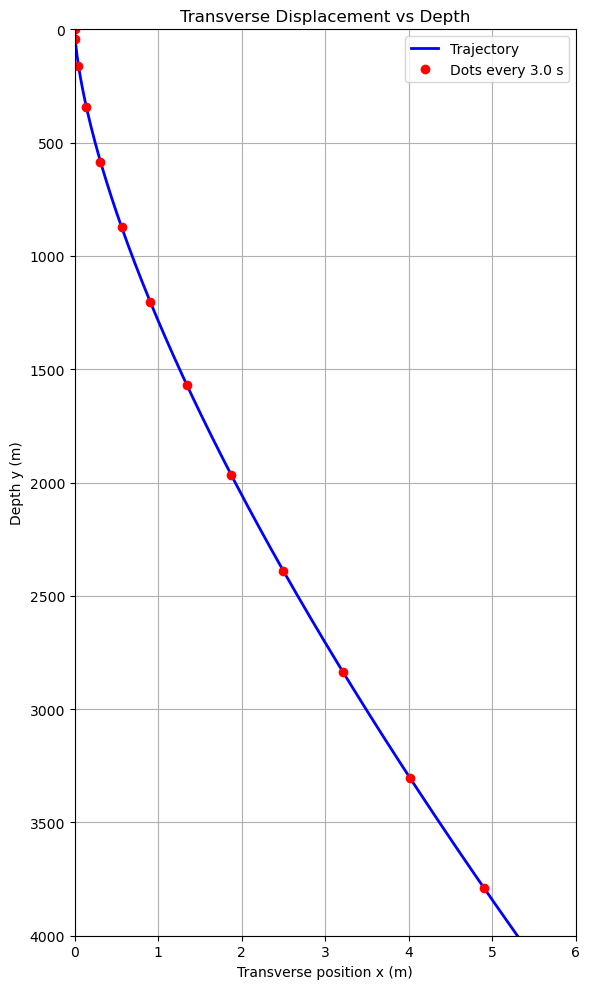

In [42]:
g = 9.81                          # gravitational acceleration (m/s^2)
shaft_depth = 4000.0              # depth of the mine shaft (m)
shaft_width = 5.0                 # shaft width (m)
gamma = 0.0                       # drag coefficient (s^-1); set 0 for no drag

# Initial conditions: [x, vx, y, vy]
# x: transverse position (east), y: depth (downwards)
init_state = [0.0, 0.0, 0.0, 0.0]

def dynamics(t, state, g, Omega, gamma):
    x, vx, y, vy = state
    dxdt = vx
    dvxdt = 2 * Omega * vy - gamma * vx
    dydt = vy
    dvy_dt = g - 2 * Omega * vx - gamma * vy
    return [dxdt, dvxdt, dydt, dvy_dt]

def depth_event(t, state):
    return state[2] - shaft_depth
depth_event.terminal = True
depth_event.direction = 1

def simulate_fall(t_max, init_state, g, Omega, gamma, shaft_depth):
    sol = solve_ivp(fun=lambda t, y: dynamics(t, y, g, Omega, gamma), t_span=[0, t_max], y0=init_state, events=depth_event, dense_output=True, max_step=0.1)
    return sol

def plot_trajectory(sol, dot_interval=3.0):
    t_vals = sol.t
    x_vals = sol.y[0]
    y_vals = sol.y[2]

    fig, ax = plt.subplots(figsize=(6, 10))
    
    # Plot the full trajectory as a blue line.
    ax.plot(x_vals, y_vals, '-', label='Trajectory', color='blue', lw=2)
    
    # Determine times for red dots (using dense output) up to the final time.
    t_dots = np.arange(t_vals[0], t_vals[-1], dot_interval)
    sol_dense = sol.sol(t_dots)
    x_dots = sol_dense[0]
    y_dots = sol_dense[2]
    
    # Plot red dots (only markers, no line connecting them).
    ax.plot(x_dots, y_dots, 'o', linestyle='None', color='red', markersize=6, label=f'Dots every {dot_interval} s')

    ax.set_xlabel('Transverse position x (m)')
    ax.set_ylabel('Depth y (m)')
    ax.set_title('Transverse Displacement vs Depth')
    ax.grid(True)
    ax.legend()

    # Set x-axis limits: since x should be about 5-6 m maximum.
    ax.set_xlim(0, 6)
    # Set y-axis limits: y from 0 (top) to shaft_depth (bottom).
    ax.set_ylim(0, shaft_depth)
    # Invert y-axis so that the top (0 m) is at the top of the plot.
    ax.invert_yaxis()

    plt.tight_layout()
    

if __name__ == '__main__':
    t_max = 1000.0  # maximum integration time (s)

    # Simulate without drag (gamma = 0)
    sol_no_drag = simulate_fall(t_max, init_state, g, Omega, gamma, shaft_depth)
    print(f"Simulation without drag completed. Final time: {sol_no_drag.t[-1]:.2f} s")
    print("Event time:", sol_no_drag.t_events)
    plot_trajectory(sol_no_drag)

    # Now simulate with drag (e.g., gamma = 0.05 s^-1)
    gamma_drag = 0.05
    sol_drag = simulate_fall(t_max, init_state, g, Omega, gamma_drag, shaft_depth)
    print(f"Simulation with drag (gamma={gamma_drag}) completed. Final time: {sol_drag.t[-1]:.2f} s")
    print("Event time:", sol_drag.t_events)
    plot_trajectory(sol_drag)


Part 4

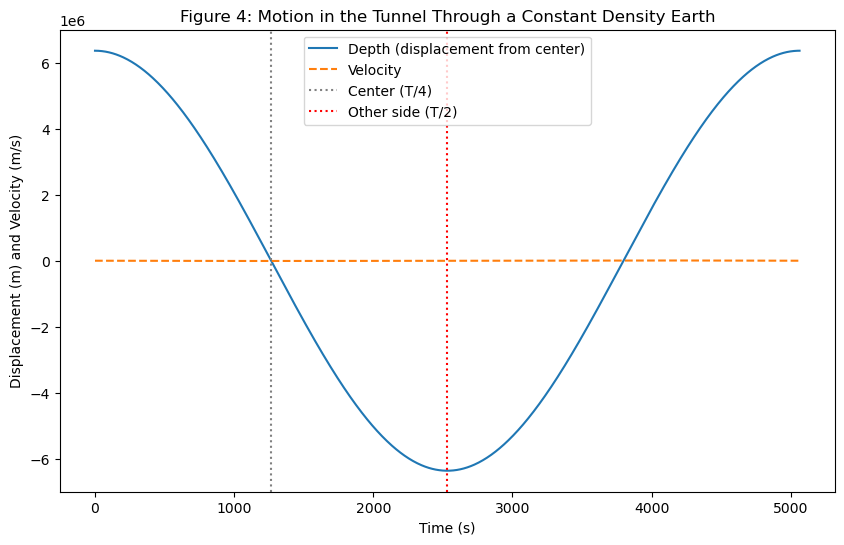

In [45]:
R = 6.37e6              # Earth's radius in meters
g = 9.81                # Acceleration due to gravity in m/s^2
Omega = np.sqrt(g / R)  # Angular frequency
T = 2 * np.pi / Omega   # full period of oscillation

# Key time instants
t_center = T / 4      # time to reach the center of the Earth
t_other = T / 2       # time to reach the other end of the tunnel (the other side)
v_max = R * Omega     # maximum speed (at the center)
t = np.linspace(0, T, 1000)

r = R * np.cos(Omega * t)               #Displacement(R is measured from the center)
v = -R * Omega * np.sin(Omega * t)      #Velocity

#Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t, r, label='Depth (displacement from center)')
ax.plot(t, v, label='Velocity', linestyle='--')
ax.axvline(t_center, color='gray', linestyle=':', label='Center (T/4)')
ax.axvline(t_other, color='red', linestyle=':', label='Other side (T/2)')

ax.set_xlabel("Time (s)")
ax.set_ylabel("Displacement (m) and Velocity (m/s)")
ax.set_title("Figure 4: Motion in the Tunnel Through a Constant Density Earth")
ax.legend()

PART 5

Fall Time to Center and Speed at Center (absolute value):
n =  0: t_center =  1265.77 s, |v_center| =  7905.04 m/s
n =  1: t_center =  1095.15 s, |v_center| = 10457.39 m/s
n =  2: t_center =  1033.79 s, |v_center| = 12182.49 m/s
n =  9: t_center =   942.61 s, |v_center| = 18370.13 m/s


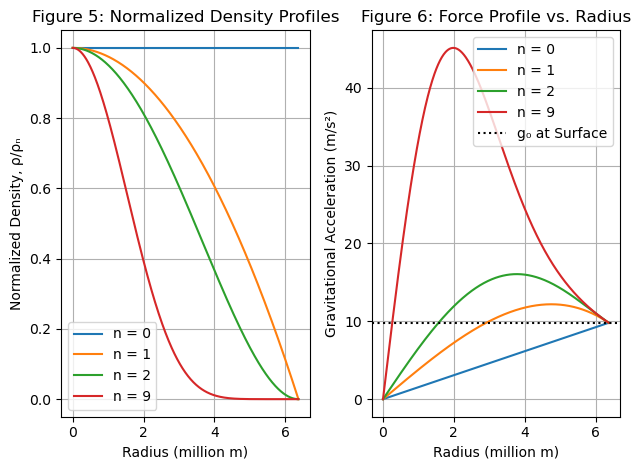

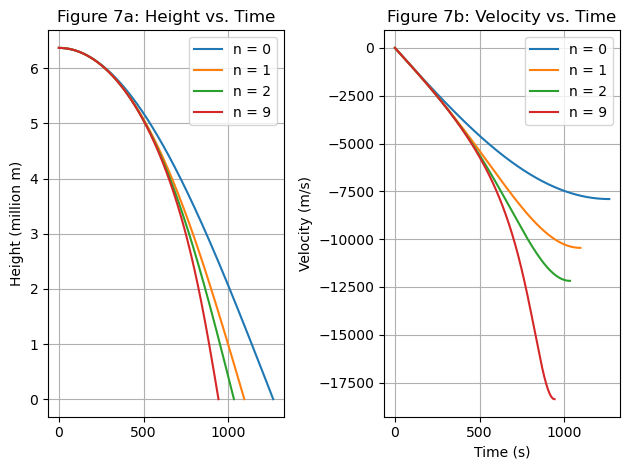

In [71]:
G = 6.67430e-11     # Gravitational constant (m^3 kg^-1 s^-2)
g0 = 9.81           # Surface gravitational acceleration (m/s^2)
R = 6.37e6          # Earth's radius (m)

#Exponents
n_values = [0, 1, 2, 9]

#Functions
def I_of_n(n): #I(n) = ∫₀¹ (1 - x²)^n * x² dx  (Using this factor to normalize density to ensure surface acceleration is g0)
    val, err = quad(lambda x: (1 - x**2)**n * x**2, 0, 1)
    return val

def J_of_n(n, xi): #J(n, xi) = ∫₀^(xi) (1 - x²)^n * x² dx where xi = r/R
    val, err = quad(lambda x: (1 - x**2)**n * x**2, 0, xi)
    return val

def density_normalized(r, n): #ρ_norm(r)= (1 - (r/R)²)^n. Setting ρₙ = 1 for plot. Returning normalized density profile as f(r)
    return (1 - (r/R)**2)**n

def rho_n(n): #Compute the normalization constant ρₙ so that g(R)=g0.
    I_val = I_of_n(n)
    return g0 / (4 * np.pi * G * R * I_val)

def acceleration(r, n, I_val): #Computing gravitational acceleration at radius r for a given exponent n
    if r < 1e-6:  # Avoid division by zero
        return 0.0
    xi = r / R
    J_val = J_of_n(n, xi)
    return - (g0 * R**2 / I_val) * (J_val / r**2)

# Derivative function for the falling object.
def deriv(t, state, n, I_val):
    r, v = state
    a = acceleration(r, n, I_val)
    return [v, a]

# Event function
def event_r_zero(t, state, n, I_val):
    return state[0]
event_r_zero.terminal = True
event_r_zero.direction = -1

#-------------------- Figure 5: Normalized Density Profiles ------------------ Figure 6: Force Profile -------------------------
fig, (ax, ax1) = plt.subplots(1,2)

r_vals = np.linspace(0, R, 500)
for n in n_values:
    dens = density_normalized(r_vals, n)
    ax.plot(r_vals / 1e6, dens, label=f"n = {n}")
ax.set_xlabel("Radius (million m)")
ax.set_ylabel("Normalized Density, ρ/ρₙ")
ax.set_title("Figure 5: Normalized Density Profiles")
ax.legend()
ax.grid(True)
fig.tight_layout()

r_plot = np.linspace(1.0, R, 500)  # start at 1 meter to avoid r=0
for n in n_values:
    I_val = I_of_n(n)  # I(n) used in the normalization
    g_profile = np.array([abs(acceleration(r, n, I_val)) for r in r_plot])
    ax1.plot(r_plot / 1e6, g_profile, label=f"n = {n}")
ax1.axhline(g0, color='black', linestyle=':', label="g₀ at Surface")
ax1.set_xlabel("Radius (million m)")
ax1.set_ylabel("Gravitational Acceleration (m/s²)")
ax1.set_title("Figure 6: Force Profile vs. Radius")
ax1.legend()
ax1.grid(True)
fig.tight_layout()

#-------------------- Figure 7: Time Evolution (Position & Velocity) --------------------
t_center_analytic_n0 = (np.pi/2) * np.sqrt(R / g0)  #maximum integration time(for constant density(n =0))
t_max = 3000  # seconds (adjust if needed)

#Plots
fig, (ax1, ax2) = plt.subplots(1,2)

# # Dictionary to store event (center) times and speeds.
results = {}

for n in n_values:
    I_val = I_of_n(n)
    
    #Event Function
    event_fun = lambda t, y: event_r_zero(t, y, n, I_val)
    event_fun.terminal = True
    event_fun.direction = -1

    sol = solve_ivp(fun=lambda t, y: deriv(t, y, n, I_val), t_span=(0, t_max), y0=[R, 0.0], events=event_fun, dense_output=True, max_step=1.0, rtol=1e-8, atol=1e-10)
    t_sol = sol.t
    r_sol = sol.y[0]
    v_sol = sol.y[1]

    ax1.plot(t_sol, r_sol / 1e6, label=f"n = {n}")
    ax2.plot(t_sol, v_sol, label=f"n = {n}")

    ax1.set_ylabel("Height (million m)")
    ax1.set_title("Figure 7a: Height vs. Time")
    ax1.grid(True)
    ax1.legend()

    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Velocity (m/s)")
    ax2.set_title("Figure 7b: Velocity vs. Time")
    ax2.grid(True)
    ax2.legend()
    fig.tight_layout()
    
#Time Recod to reach r = 0 and the speed at that time.
    if sol.t_events[0].size > 0:
        t_center = sol.t_events[0][0]
        # Solution at the event time to get v.
        state_center = sol.sol(t_center)
        v_center = state_center[1]
        results[n] = (t_center, abs(v_center))
    else:
        results[n] = (np.nan, np.nan)

print("Fall Time to Center and Speed at Center (absolute value):")
for n in n_values:
    t_center, v_center = results[n]
    print(f"n = {n:>2}: t_center = {t_center:8.2f} s, |v_center| = {v_center:8.2f} m/s")


Moon fall time (surface to center):
  1625.55 s, which is approximately 27.09 minutes.

Density comparison (Moon/Earth):
  0.606 (Moon's density is about 61% that of Earth)


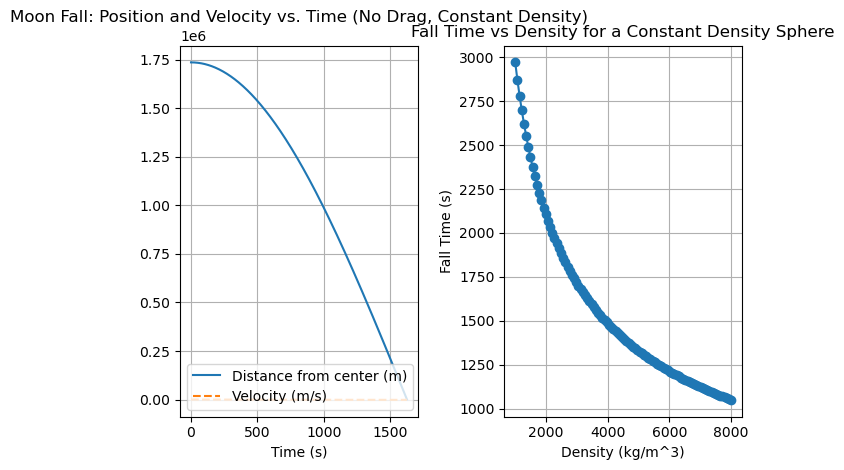

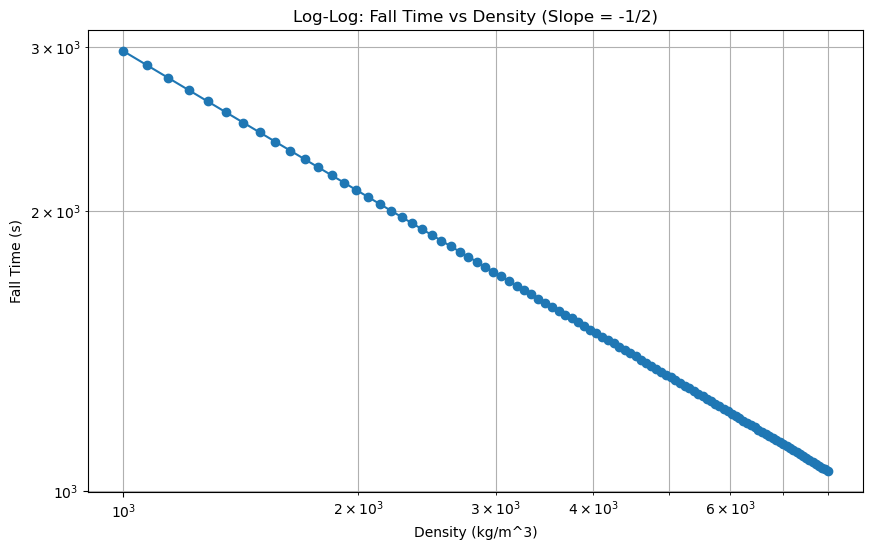

In [78]:
G = 6.67430e-11                                   #Gravitational constant (m^3 kg^-1 s^-2)
pi = np.pi                                        #Pi
R_moon = 1.7371e6                                 #Moon's radius in meters
rho_moon = 3340                                   #Moon's constant density in kg/m^3
Omega_moon = np.sqrt((4 * pi / 3) * G * rho_moon) #Angular frequency
T_fall_moon = pi / (2 * Omega_moon)               # Fall time from the surface (r = R) to the center (r = 0)

print("Moon fall time (surface to center):")
print(f"  {T_fall_moon:.2f} s, which is approximately {T_fall_moon/60:.2f} minutes.")

#Density Comparison
rho_earth = 5515             
density_ratio = rho_moon / rho_earth
print("\nDensity comparison (Moon/Earth):")
print(f"  {density_ratio:.3f} (Moon's density is about {density_ratio*100:.0f}% that of Earth)")

#Time Evolution of Falling Object on the Moon
t_vals = np.linspace(0, T_fall_moon, 500)                     #time values from t=0 to t = fall time
r_vals = R_moon * np.cos(Omega_moon * t_vals)                 #radial distance from center
v_vals = -R_moon * Omega_moon * np.sin(Omega_moon * t_vals)

#Dependence of Fall Time on Density ---
densities = np.linspace(1000, 8000, 100)  #Array of densities (in kg/m^3) to explore the dependence
T_fall_array = (pi/2) * np.sqrt(3 / (4 * pi * G * densities))

# Plot
fig, (ax, ax2) = plt.subplots(1, 2)
ax.plot(t_vals, r_vals, label='Distance from center (m)')
ax.plot(t_vals, v_vals, label='Velocity (m/s)', linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_title('Moon Fall: Position and Velocity vs. Time (No Drag, Constant Density)')
ax.legend(loc='lower left')
ax.grid(True)

ax2.plot(densities, T_fall_array, marker='o', linestyle='-')
ax2.set_xlabel('Density (kg/m^3)')
ax2.set_ylabel('Fall Time (s)')
ax2.set_title('Fall Time vs Density for a Constant Density Sphere')
ax2.grid(True)
fig.tight_layout()

fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.loglog(densities, T_fall_array, marker='o', linestyle='-')
ax3.set_xlabel('Density (kg/m^3)')
ax3.set_ylabel('Fall Time (s)')
ax3.set_title('Log-Log: Fall Time vs Density (Slope = -1/2)')
ax3.grid(True, which='both')
plt.show()


In [23]:
def Solomon(x):
    if 'Solomon' >= 'Drink Coffee':
        return 'Dead'
    else:
        return 'Thankfully Alive'
print(f"Solomon is {Solomon >= 'Drink Coffee' -1:.1f}")

TypeError: unsupported operand type(s) for -: 'str' and 'int'